MOVE STUFF HERE FROM skillcornerSmooth.ipynb

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import isnan, sqrt
from datetime import datetime
from smoothing import performSmoothing, euclidianDistance

In [3]:
import csv

def read_csv_partially(file_path, start_line, end_line):
    data = []  # List to store extracted CSV rows

    with open(file_path, 'r', newline='') as file:
        reader = csv.reader(file)
        for line_num, row in enumerate(reader):
            if line_num >= start_line and line_num <= end_line:
                # Append the row to data
                data.append(row)
            elif line_num > end_line:
                break  # Stop reading once end_line is reached

    return data

In [4]:
file_path_skillcorner = '../data/matches/Feb/1384039_tracking.csv'
lineup_path = '../data/matches/Feb/1384039_lineup.csv'
partialframes = read_csv_partially(file_path_skillcorner, 0, 1500000)

lineup = read_csv_partially(lineup_path, 0, 33)
# targetIDSkillcorner = 7679
targetIDSkillcorner = 10218
targetPositionsSkillcorner = []

def getTrajectories(teamName, lineup, partialframes):
    playerIDs = set()
    teamName = "FC Basel"

    for player in list(filter(lambda player: player[1] == teamName, lineup[1:])):
        playerIDs.add(str(player[2]))

    targetTrajs = {}
    playerSmoothDataFrames = pd.DataFrame()
    for ID in playerIDs:
        targetTrajs[ID] = []
        playerSmoothDataFrames = pd.DataFrame()

    for index, playerFrame in enumerate(partialframes):

        if(playerFrame[4] not in playerIDs or playerFrame[8] == 'True'):
            continue

        # defining datapoints d_i = [x_Coordinate, y_Coordinate, speed, time]
        if targetTrajs[playerFrame[4]] == [] or int(targetTrajs[playerFrame[4]][-1][-1][-1]) != (int(playerFrame[2]) - 1):
            targetTrajs[playerFrame[4]].append([])
            
        targetTrajs[playerFrame[4]][-1].append([float(playerFrame[5]), float(playerFrame[6]), 0, datetime.fromtimestamp(int(playerFrame[3])/1000.0), int(playerFrame[2])])
    return targetTrajs

targetTrajs = getTrajectories("FC Basel", lineup, partialframes)

<h1>Time Series Analysis<h1>

<h3>Speed Smoothing</h3>

In [5]:
isolatedTraj = []
for player, trajs in targetTrajs.items():
    for traj in trajs:
        if len(traj) >= 718:
            isolatedTraj = traj
            break
# print(isolatedTraj)
smoothIsolatedTrajs = [
    performSmoothing(isolatedTraj, 1),
    performSmoothing(isolatedTraj, 5),
    performSmoothing(isolatedTraj, 10),
    performSmoothing(isolatedTraj, 50),
    performSmoothing(isolatedTraj, 100),
    performSmoothing(isolatedTraj, 150),
    performSmoothing(isolatedTraj, 200)
]
its = [
    1,
    5,
    10,
    50,
    100,
    150,
    200,
]
isolatedTraj = pd.DataFrame(isolatedTraj)


**Add Gaussian Filtering on Frecquency Domain of Speed signal**

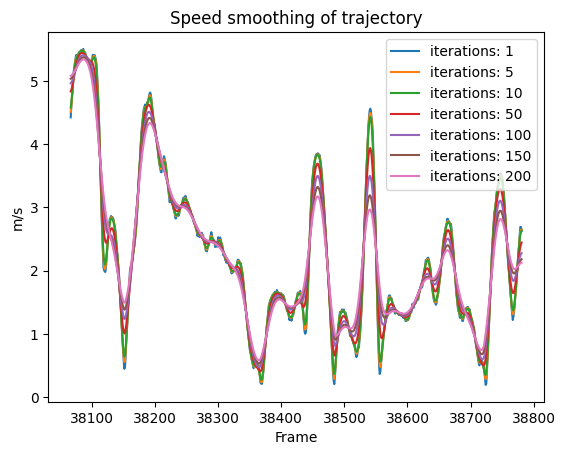

In [6]:
# plot the speed timeseries 
for i, traj in enumerate(smoothIsolatedTrajs):
    # if(i == 2):
    #     continue
    traj = pd.DataFrame(traj)
    traj[4] = isolatedTraj[4]
    traj[4] = traj[4].astype(int)

    plt.plot(traj.loc[:, 4][1:-1], (traj.loc[:, 2][1:-1]*10), color='C'+str(i), label='iterations: ' + str(its[i]))

plt.title('Speed smoothing of trajectory')
plt.xlabel('Frame')  # Replace 'Index' with the actual x-axis label
plt.ylabel('m/s')  # Replace 'Value' with the actual y-axis label
plt.legend()
# plt.xlim(38222, 38335)
plt.show()

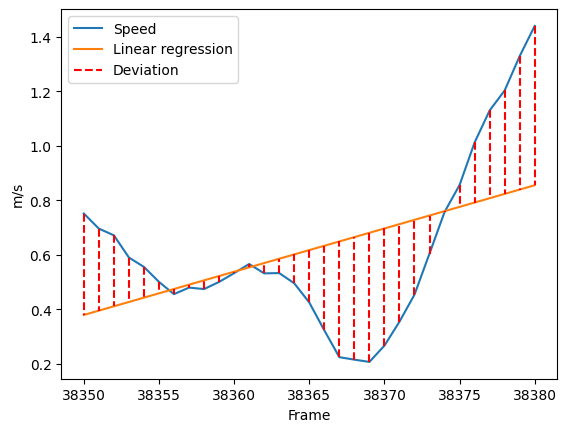

0.2775727493742209


In [7]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

speedTS = pd.DataFrame(smoothIsolatedTrajs[0])
speedTS[2] = speedTS[2]*10
speedTS.columns = ['x', 'y', 'speed', 'time', 'frame_id']
speedTS['frame_id'] = isolatedTraj[4]
speedTS = speedTS[1:-1]
speedTS = speedTS[['speed', 'frame_id']]
speedTS = speedTS[(speedTS['frame_id'] >= 38350) & (speedTS['frame_id'] <= 38380)]

lr.fit(speedTS[['frame_id']], speedTS['speed'])

slope = lr.coef_[0]
intercept = lr.intercept_

speedTS['linear'] = lr.predict(speedTS[['frame_id']])
speedTS['deviation'] = (speedTS['speed'] - speedTS['linear'])**2

plt.plot(speedTS['frame_id'], speedTS['speed'], label='Speed')
plt.plot(speedTS['frame_id'], speedTS['linear'], label='Linear regression')

count = 0
for _, row in speedTS.iterrows():
    if count == 0:
        plt.plot([row['frame_id'], row['frame_id']], [row['speed'], row['linear']], color='r', linestyle='--', label='Deviation')
    else:
        plt.plot([row['frame_id'], row['frame_id']], [row['speed'], row['linear']], color='r', linestyle='--')
    count += 1

plt.xlabel('Frame')  # Replace 'Index' with the actual x-axis label
plt.ylabel('m/s')  # Replace 'Value' with the actual y-axis label
plt.legend()
plt.show()

print(sqrt(speedTS['deviation'].sum()/len(speedTS)))
# print(speedTS['deviation'].sum())

# 0.00615298954502796

In [8]:
def getSpeedDeviation(trajectory):
    traj = pd.DataFrame(trajectory)
    lr = LinearRegression()

    speedTS = traj
    speedTS['speed'] = speedTS['speed']
    speedTS = speedTS[['speed', 'frame_id']]
    speedTS = speedTS[(speedTS['frame_id'] >= 38222) & (speedTS['frame_id'] <= 38332)]

    lr.fit(speedTS[['frame_id']], speedTS['speed'])

    speedTS['linear'] = lr.predict(speedTS[['frame_id']])
    speedTS['deviation'] = (speedTS['speed'] - speedTS['linear'])**2

    return sqrt(speedTS['deviation'].sum()/len(speedTS))

<h1>Trajectory Similarity</h1>

In [9]:
traj1 = list(map(lambda x: [x[0], x[1]], smoothIsolatedTrajs[0]))
traj2 = list(map(lambda x: [x[0], x[1]], smoothIsolatedTrajs[6]))

<h3>Dynamic Time Warping</h3>

Using: https://dtaidistance.readthedocs.io/en/latest/

In [12]:
import dtaidistance
from dtaidistance import dtw_ndim

series1 = np.array(traj1, dtype=np.double)
series2 = np.array(traj2, dtype=np.double)
d = dtw_ndim.distance(series1, series2)

Dmatrix = dtaidistance.dtw_ndim.distance_matrix(series1, series2)
d, paths = dtaidistance.dtw_ndim.warping_paths(series1, series2)
print(d)

2.3344664345151878


In [13]:
from dtaidistance import dtw_visualisation
dtw_visualisation.plot_warpingpaths(series1, series2, paths, filename="warp.png")

(None, None)

<h3>Lock-Step Distance<h3>

In [14]:
series1 = np.array(traj1, dtype=np.double)
series2 = np.array(traj2, dtype=np.double)

assert(len(series1) == len(series2))
totalDistance = 0
for (x, y) in zip(series1, series2):
    totalDistance += euclidianDistance(x, y)

print(totalDistance)

164.53829038503906


<h3>Fréchet Distance</h3>

Using: https://pypi.org/project/frechetdist/

In [15]:
import frechetdist

series1 = np.array(traj1, dtype=np.double)
series2 = np.array(traj2, dtype=np.double)

print(frechetdist.frdist(series1, series2))

0.2617430756742838


- check gps trajectory data to use as "true" reference
- add noise, experiments, longitudinal and lateral noise